In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
sns.set_palette('pastel')

import warnings
warnings.simplefilter("ignore")

In [3]:
test_df = pd.read_csv('../data/cleaned_test.csv')
train_df = pd.read_csv('../data/cleaned_train.csv')

In [4]:
train_df.head()

,cc_num,trans_date_trans_time,category,amt,lat,long,merch_lat,merch_long,is_fraud
0,2703186189652095,2019-01-01 00:00:18,misc_net,4.97,36.0788,-81.1781,36.011293,-82.048315,0
1,630423337322,2019-01-01 00:00:44,grocery_pos,107.23,48.8878,-118.2105,49.159047,-118.186462,0
2,38859492057661,2019-01-01 00:00:51,entertainment,220.11,42.1808,-112.2620,43.150704,-112.154481,0
3,3534093764340240,2019-01-01 00:01:16,gas_transport,45.00,46.2306,-112.1138,47.034331,-112.561071,0
4,375534208663984,2019-01-01 00:03:06,misc_pos,41.96,38.4207,-79.4629,38.674999,-78.632459,0


In [5]:
def add_rolling_avg_features(df):
    import pandas as pd

    # Ensure datetime format
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    # Sort data by cc_num and transaction time
    df = df.sort_values(by=['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

    # Store original index for restoring later
    original_index = df.index

    # Set datetime index temporarily
    df.set_index('trans_date_trans_time', inplace=True)

    # Group by card
    grouped = df.groupby('cc_num')

    # --- 1. Rolling features: time-based (last 1h and 24h) ---
    df['last_hour_sum'] = grouped['amt'].rolling('1h').sum().reset_index(level=0, drop=True)
    df['last_hour_count'] = grouped['amt'].rolling('1h').count().reset_index(level=0, drop=True)
    df['last_hour_avg'] = (df['last_hour_sum'] / df['last_hour_count']).round(2)

    df['last_24h_sum'] = grouped['amt'].rolling('24h').sum().reset_index(level=0, drop=True)
    df['last_24h_count'] = grouped['amt'].rolling('24h').count().reset_index(level=0, drop=True)
    df['last_24h_avg'] = (df['last_24h_sum'] / df['last_24h_count']).round(2)

    # --- 2. Rolling median of last 250 transactions (time-based, up to this row) ---
    # For each cc_num group, apply rolling window of 250 and compute median
    rolling_100_medians = (
        grouped['amt']
        .rolling(window=100, min_periods=1)
        .median()
        .reset_index(level=0, drop=True)
    )

    df['last_100_median'] = rolling_100_medians
    

    # --- 3. Restore index ---
    df.reset_index(inplace=True)
    df.index = original_index

    # --- 4. Fill NaNs ---
    df['last_hour_avg'] = df['last_hour_avg'].fillna(0)
    df['last_24h_avg'] = df['last_24h_avg'].fillna(0)
    df['last_100_median'] = df['last_100_median'].fillna(0)

    return df

# Apply to both train and test
train = add_rolling_avg_features(train_df)
test = add_rolling_avg_features(test_df)

train.head()

,trans_date_trans_time,cc_num,category,amt,lat,long,merch_lat,merch_long,is_fraud,last_hour_sum,last_hour_count,last_hour_avg,last_24h_sum,last_24h_count,last_24h_avg,last_100_median
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,43.0048,-108.8964,43.974711,-109.741904,0,7.27,1.0,7.27,7.27,1.0,7.27,7.270
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,43.0048,-108.8964,42.018766,-109.044172,0,52.94,1.0,52.94,60.21,2.0,30.10,30.105
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,43.0048,-108.8964,42.961335,-109.157564,0,135.02,2.0,67.51,142.29,3.0,47.43,52.940
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,43.0048,-108.8964,42.228227,-108.747683,0,34.79,1.0,34.79,177.08,4.0,44.27,43.865
4,2019-01-02 13:10:46,60416207185,home,27.18,43.0048,-108.8964,43.321745,-108.091143,0,61.97,2.0,30.98,196.99,4.0,49.25,34.790


In [7]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [8]:
def process_data(df, lat_col, long_col, merch_lat_col, merch_long_col, group_col):
    # Calculate distance between transaction and merchant
    df['dist'] = haversine(df[lat_col], df[long_col], df[merch_lat_col], df[merch_long_col])
    # Calculate distance from the previous transaction
    df['prev_dist'] = df.groupby(group_col)['dist'].shift(1)
    # Fill NaN values for the first transaction with the current distance
    df['prev_dist'].fillna(df['dist'], inplace=True)
    # Calculate the difference between current and previous distances
    df['dist_diff'] = abs(df['dist'] - df['prev_dist'])
    # Drop unnecessary columns
    df.drop(columns=[lat_col, long_col, merch_lat_col, merch_long_col, 'prev_dist'], inplace=True)
    return df

train = process_data(train, 'lat', 'long', 'merch_lat', 'merch_long', 'cc_num')
test = process_data(test, 'lat', 'long', 'merch_lat', 'merch_long', 'cc_num')
train.head()

,trans_date_trans_time,cc_num,category,amt,is_fraud,last_hour_sum,last_hour_count,last_hour_avg,last_24h_sum,last_24h_count,last_24h_avg,last_100_median,dist,dist_diff
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,0,7.27,1.0,7.27,7.27,1.0,7.27,7.270,127.606239,0.000000
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,0,52.94,1.0,52.94,60.21,2.0,30.10,30.105,110.308921,17.297318
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,0,135.02,2.0,67.51,142.29,3.0,47.43,52.940,21.787261,88.521660
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,0,34.79,1.0,34.79,177.08,4.0,44.27,43.865,87.204215,65.416954
4,2019-01-02 13:10:46,60416207185,home,27.18,0,61.97,2.0,30.98,196.99,4.0,49.25,34.790,74.212965,12.991250


In [9]:
# Part of the Day
def categorize_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour or hour < 5:
        return 'Night'

# For test
test['hour'] = test['trans_date_trans_time'].dt.hour
test['part_of_day'] = test['hour'].apply(categorize_part_of_day)
test.drop(columns=['hour'], inplace=True)
# test['is_weekend'] = test['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

# For train
train['hour'] = train['trans_date_trans_time'].dt.hour
train['part_of_day'] = train['hour'].apply(categorize_part_of_day)
train.drop(columns=['hour'], inplace=True)
# train['is_weekend'] = train['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

train.head()

,trans_date_trans_time,cc_num,category,amt,is_fraud,last_hour_sum,last_hour_count,last_hour_avg,last_24h_sum,last_24h_count,last_24h_avg,last_100_median,dist,dist_diff,part_of_day
0,2019-01-01 12:47:15,60416207185,misc_net,7.27,0,7.27,1.0,7.27,7.27,1.0,7.27,7.270,127.606239,0.000000,Afternoon
1,2019-01-02 08:44:57,60416207185,gas_transport,52.94,0,52.94,1.0,52.94,60.21,2.0,30.10,30.105,110.308921,17.297318,Morning
2,2019-01-02 08:47:36,60416207185,gas_transport,82.08,0,135.02,2.0,67.51,142.29,3.0,47.43,52.940,21.787261,88.521660,Morning
3,2019-01-02 12:38:14,60416207185,kids_pets,34.79,0,34.79,1.0,34.79,177.08,4.0,44.27,43.865,87.204215,65.416954,Afternoon
4,2019-01-02 13:10:46,60416207185,home,27.18,0,61.97,2.0,30.98,196.99,4.0,49.25,34.790,74.212965,12.991250,Afternoon


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   category               1296675 non-null  object        
 3   amt                    1296675 non-null  float64       
 4   is_fraud               1296675 non-null  int64         
 5   last_hour_sum          1296675 non-null  float64       
 6   last_hour_count        1296675 non-null  float64       
 7   last_hour_avg          1296675 non-null  float64       
 8   last_24h_sum           1296675 non-null  float64       
 9   last_24h_count         1296675 non-null  float64       
 10  last_24h_avg           1296675 non-null  float64       
 11  last_100_median        1296675 non-null  float64       
 12  dist                   12966

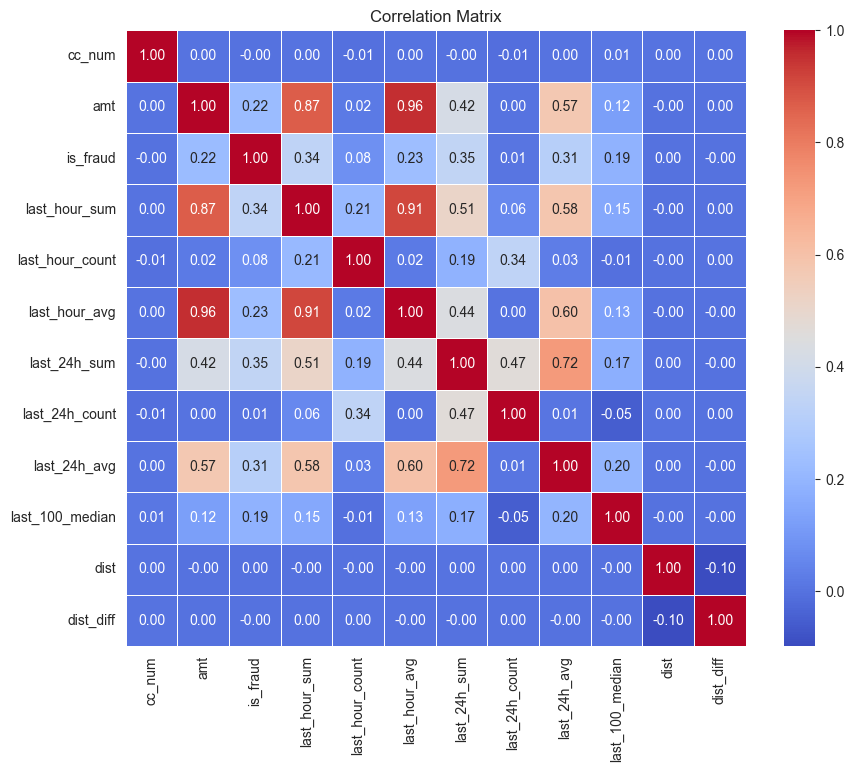

In [11]:
numeric_columns = train.select_dtypes(include=['float64', 'int64', 'int32']).columns
correlation_matrix = train[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
test.to_csv('../data/Filtered_test.csv', index=False)
train.to_csv('../data/Filtered_train.csv', index=False)

In [13]:
fraud = train[train['is_fraud'] == 1]
non_fraud = train[train['is_fraud'] == 0]

In [14]:
non_fraud.shape

(1289169, 15)

In [15]:
# Get the size of the fraud dataset
fraud_size = fraud.shape[0]

# Calculate the target size for the non-fraud dataset
# reducing it to this size gives a better performance
target_size = fraud_size * 70

# Resample the non-fraud dataset with replacement if needed
resampled_non_fraud = non_fraud.sample(n=target_size, replace=(non_fraud.shape[0] < target_size), random_state=42)

# Combine the fraud and resampled non-fraud datasets if needed
balanced_dataset = pd.concat([fraud, resampled_non_fraud])

# Check the new dataset shape
print("Fraud dataset shape:", fraud.shape)
print("Non-fraud dataset shape after resampling:", resampled_non_fraud.shape)
print("Balanced dataset shape:", balanced_dataset.shape)

Fraud dataset shape: (7506, 15)
Non-fraud dataset shape after resampling: (525420, 15)
Balanced dataset shape: (532926, 15)


In [16]:
def preprocess_data(df):
    columns_to_drop = ['cc_num', 'trans_date_trans_time', 'amt']
    df = df.drop(columns=columns_to_drop)

    # One-hot encode columns
    part_of_day_onehot = pd.get_dummies(df.part_of_day, prefix='D', drop_first=True)
    category_onehot = pd.get_dummies(df.category, prefix='category', drop_first=True)
    df = pd.concat([df, part_of_day_onehot.astype(int), category_onehot.astype(int)], axis=1)

    return df.drop(columns=['category', 'part_of_day'])

# Preprocess the test and train datasets
test = preprocess_data(test)
# train = preprocess_data(train)
balanced_dataset = preprocess_data(balanced_dataset)
# train.head(2)

In [17]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532926 entries, 115 to 1286284
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   is_fraud                 532926 non-null  int64  
 1   last_hour_sum            532926 non-null  float64
 2   last_hour_count          532926 non-null  float64
 3   last_hour_avg            532926 non-null  float64
 4   last_24h_sum             532926 non-null  float64
 5   last_24h_count           532926 non-null  float64
 6   last_24h_avg             532926 non-null  float64
 7   last_100_median          532926 non-null  float64
 8   dist                     532926 non-null  float64
 9   dist_diff                532926 non-null  float64
 10  D_Evening                532926 non-null  int32  
 11  D_Morning                532926 non-null  int32  
 12  D_Night                  532926 non-null  int32  
 13  category_food_dining     532926 non-null  int32  
 14  catego

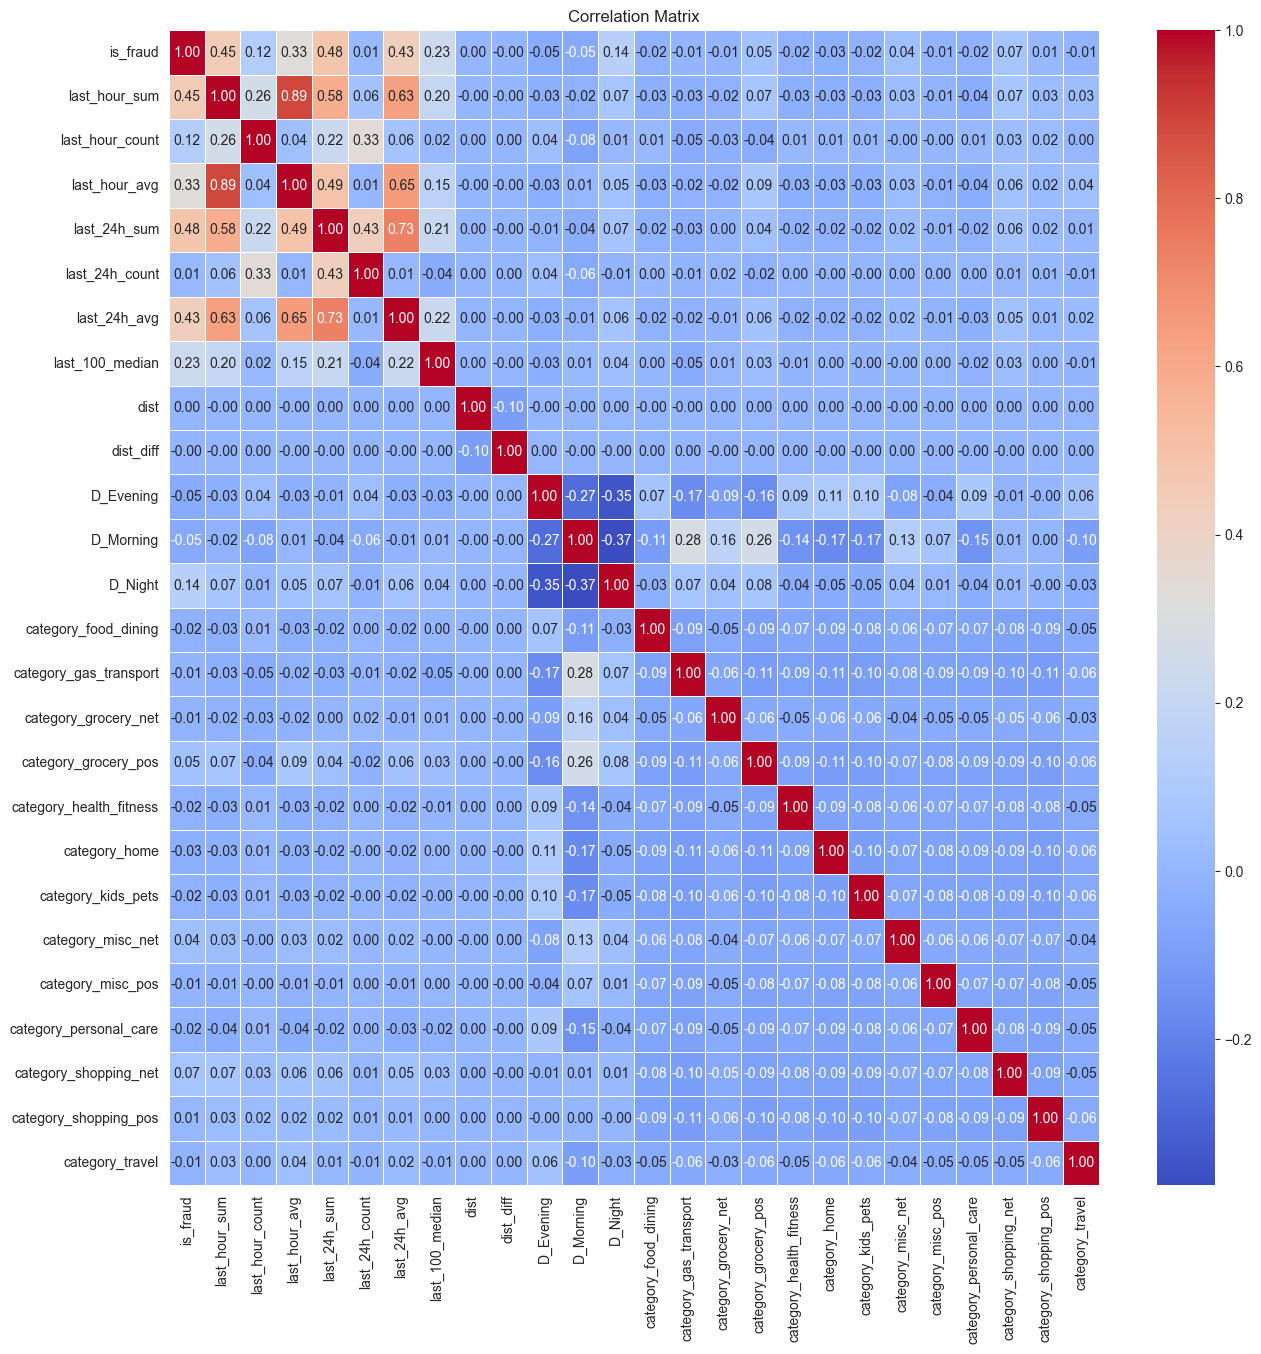

In [19]:
correlation_matrix = balanced_dataset.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [108]:
X=balanced_dataset.drop(columns=['is_fraud'])
y=balanced_dataset['is_fraud']

# x=train.drop(columns=['is_fraud'])
# y=train['is_fraud']

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3,random_state=42)

In [31]:
from sklearn import metrics

def visualize_evaluation(y_test, y_pred, y_pred_proba=None):
    """
    Visualize evaluation metrics in vertical layout including:
    - Confusion Matrix
    - ROC Curve (if y_pred_proba is provided)
    - Metrics Bar Chart
    """
    
    # Create figure with vertical subplots
    fig = plt.figure(figsize=(8, 12))
    
    # Determine number of subplots (2 or 3 depending on ROC)
    n_subplots = 3 if y_pred_proba is not None else 2
    plot_index = 1
    
    # 1. Confusion Matrix
    plt.subplot(n_subplots, 1, plot_index)
    plot_index += 1
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    
    # 2. ROC Curve (only if probabilities are provided)
    if y_pred_proba is not None:
        plt.subplot(n_subplots, 1, plot_index)
        plot_index += 1
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
    
    # 3. Metrics Bar Chart (vertical bars)
    plt.subplot(n_subplots, 1, plot_index)
    metrics_dict = {
        'Accuracy': metrics.accuracy_score(y_test, y_pred),
        'Precision': metrics.precision_score(y_test, y_pred),
        'Recall': metrics.recall_score(y_test, y_pred),
        'F1 Score': metrics.f1_score(y_test, y_pred)
    }
    if y_pred_proba is not None:
        metrics_dict['AUC'] = auc
    
    # Create vertical bar plot
    sns.barplot(x=list(metrics_dict.keys()), 
                y=list(metrics_dict.values()),
                palette='viridis')
    plt.title('Model Metrics')
    plt.ylim(0, 1)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of bars
    for i, v in enumerate(metrics_dict.values()):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.show()

In [112]:
from sklearn import metrics
def evaluate_model(model, x_test, y_test):
    # Predict Test Data 
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    
    # Calculate metrics
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    # Print metrics
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 Score:', f1)
    print('Cohens Kappa Score:', kappa)
    print('Area Under Curve:', auc)
    
    # Visualize results
    visualize_evaluation(y_test, y_pred, y_pred_proba)

In [ ]:
#Building Random Forest Model
rf_clf = RandomForestClassifier(n_estimators = 50,max_depth = 20,
                                random_state=345, n_jobs=-1, verbose = 1)
rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished


RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1,
                       random_state=345, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.9971478252167277
Precision: 0.9409722222222222
Recall: 0.8491495076096688
F1 Score: 0.8927058823529411
Cohens Kappa Score: 0.8912644387475528
Area Under Curve: 0.9963738727902656


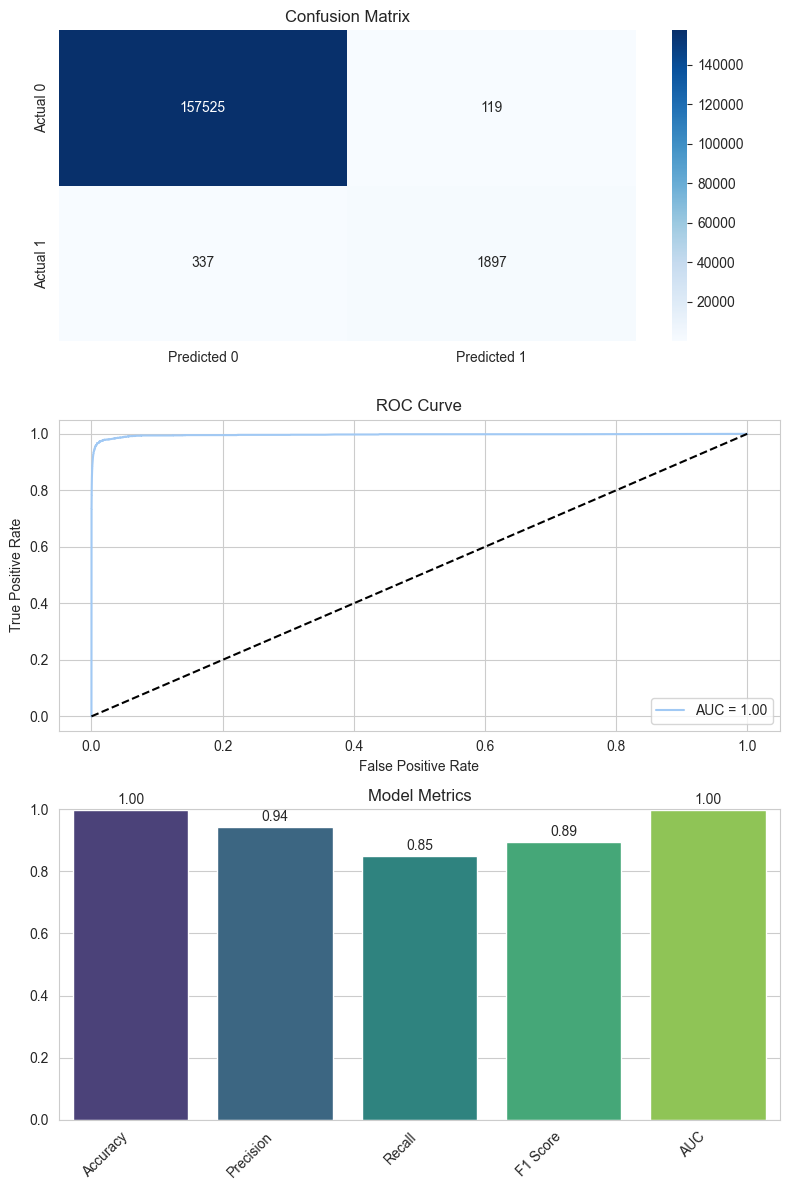

In [32]:
# Evaluate Model
rf_eval = evaluate_model(rf_clf, X_val, y_val)

In [33]:
import pickle
# Save the model
with open("../artifacts/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_clf, f)

In [34]:
import pickle
# loading the model
with open("../artifacts/random_forest_model.pkl", "rb") as f:
    rf_clf = pickle.load(f)

In [110]:
x_test=test.drop(columns=['is_fraud'])
y_test=test['is_fraud']

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


Accuracy: 0.9985802176999526
Precision: 0.8376494023904383
Recall: 0.7841491841491841
F1 Score: 0.810016855285336
Cohens Kappa Score: 0.8093050799280342
Area Under Curve: 0.9926615029508228


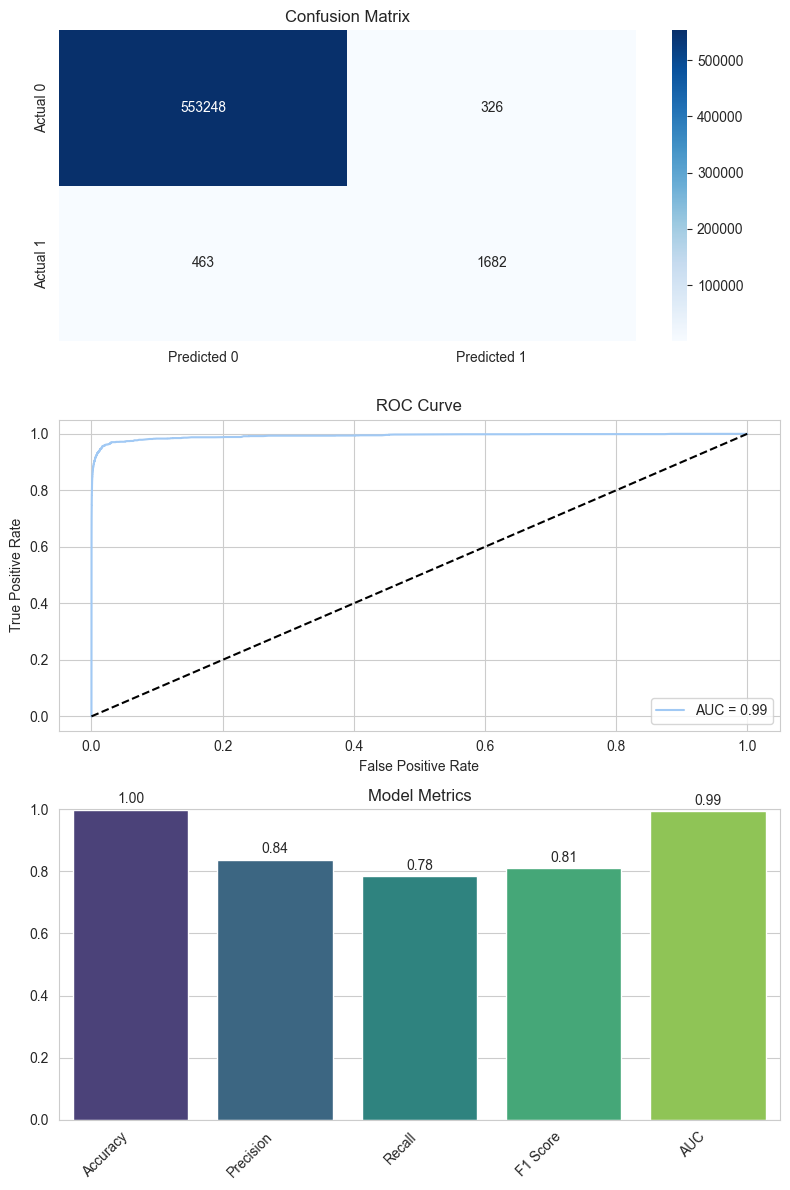

In [113]:
lr_real = evaluate_model(rf_clf, x_test, y_test)

# Anamoly Detection

In [37]:
# Transform scores to make fraud cases have higher values
def transform_scores(scores, max_score, min_score):
    """
    Convert Isolation Forest scores to fraud scores where:
    - Higher values indicate higher probability of fraud
    - Scores range from 0 (normal) to 100 (definite fraud)
    """
    # Shift scores so anomalies are positive
    shifted = -scores  # Invert the scores
    
    # Normalize to 0-100 range
    normalized = 100 * (shifted - min_score) / (max_score - min_score)
    normalized = np.clip(normalized, 0, 100)
    
    return normalized

In [123]:
def eval_model(model, x_test, y_test, max_score, min_score):
    from sklearn import metrics

    # Predict Test Data
    y_pred = model.predict(x_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]

    # Generate confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Generate classification report
    report = metrics.classification_report(y_test, y_pred)
    print("\nClassification Report:\n", report)

    # Calculate ROC-AUC 
    y_prob = model.decision_function(x_test)  # Use decision_function for Isolation Forest
    val_proba = transform_scores(y_prob, max_score, min_score)
    val_proba = (val_proba > 42.5).astype(int)
    y_prob = (y_prob < 4.0/100).astype(int)
    roc_auc = metrics.roc_auc_score(y_test, y_prob)
    roc_auc_transfrom = metrics.roc_auc_score(y_test, val_proba)
    print("\nROC-AUC Score:", roc_auc)
    print("ROC-AUC Score (transformed):", roc_auc_transfrom)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import IsolationForest
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',  # Let the algorithm estimate the fraud rate
    max_features=1.0,
    bootstrap=False,
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit the model
iso_forest.fit(X_train)

# Calculate anomaly scores (-1 to 1 where -1 is most anomalous)
train_scores = iso_forest.decision_function(X_train)
val_scores = iso_forest.decision_function(X_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


In [39]:
max_score = np.max(train_scores)
min_score = np.min(train_scores)

train_proba = transform_scores(train_scores, max_score, min_score)
val_proba = transform_scores(val_scores, max_score, min_score)

# Create DataFrames with the results
train_results = pd.DataFrame({
    'actual': y_train,
    'score': train_scores,
    'fraud_probability': train_proba
})

val_results = pd.DataFrame({
    'actual': y_val,
    'score': val_scores,
    'fraud_probability': val_proba
})

<Axes: xlabel='fraud_probability', ylabel='Density'>

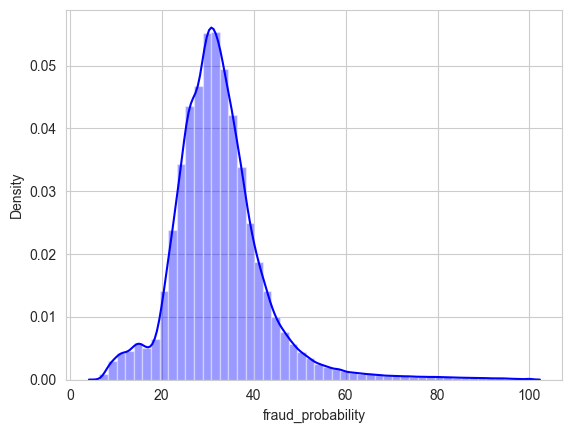

In [40]:
sns.distplot(train_results['fraud_probability'], kde=True, color='blue', label='Train Fraud Probability')

In [45]:
# Convert probabilities to binary predictions using a threshold
threshold = 64.6469  # Adjust based on your business needs
val_results['predicted'] = (val_results['fraud_probability'] > threshold).astype(int)
val_results["score_pred"] = (val_results["score"] < 4.0/100).astype(int)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(val_results['actual'], val_results['predicted']))
print(confusion_matrix(val_results['actual'], val_results['score_pred']))

print("\nClassification Report:")
print(classification_report(val_results['actual'], val_results['predicted']))
print(classification_report(val_results['actual'], val_results['score_pred']))

print("\nROC AUC Score:", roc_auc_score(val_results['actual'], val_results['fraud_probability']))
print("\nROC AUC Score:", roc_auc_score(val_results['actual'], val_results['score_pred']))

Confusion Matrix:
[[104505    580]
 [   648    853]]
[[93574 11511]
 [  195  1306]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    105085
           1       0.60      0.57      0.58      1501

    accuracy                           0.99    106586
   macro avg       0.79      0.78      0.79    106586
weighted avg       0.99      0.99      0.99    106586

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    105085
           1       0.10      0.87      0.18      1501

    accuracy                           0.89    106586
   macro avg       0.55      0.88      0.56    106586
weighted avg       0.99      0.89      0.93    106586


ROC AUC Score: 0.94203527444884

ROC AUC Score: 0.8802733563264686


In [44]:
# To find optimal threshold (example)
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    val_results['actual'], 
    val_results['fraud_probability']
)

# Find threshold that gives best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold:.4f}")

Optimal threshold: 64.6469


In [46]:
import joblib

# Save the trained Isolation Forest model to a file
joblib.dump(iso_forest, "../artifacts/iso_forest_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [47]:
# Load the saved model
iso_forest_loaded = joblib.load("../artifacts/iso_forest_model.pkl")
print("Model loaded successfully!")

Model loaded successfully!


In [124]:
# Predict the outliers on the on a real set
y_pred_test = iso_forest.predict(x_test)
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]

print("\nTest Results:")
eval_model(iso_forest, x_test, y_test, max_score, min_score)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s



Test Results:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s


Confusion Matrix:
 [[537689  15885]
 [   564   1581]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    553574
           1       0.09      0.74      0.16      2145

    accuracy                           0.97    555719
   macro avg       0.54      0.85      0.57    555719
weighted avg       1.00      0.97      0.98    555719



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s



ROC-AUC Score: 0.8623922998761774
ROC-AUC Score (transformed): 0.864740198135914
